# Dastasets para generar Dashboard

## Crear sesión de spark

In [9]:
from pyspark.sql.session import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
import seaborn as sns
import matplotlib.pyplot as plt

# Seaborn configuration
sns.set(rc={"figure.figsize":(16, 9)})

In [2]:
spark = SparkSession.builder.appName("Dashboard").getOrCreate()
print(spark.version)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/14 14:13:04 INFO SparkEnv: Registering MapOutputTracker
25/01/14 14:13:04 INFO SparkEnv: Registering BlockManagerMaster
25/01/14 14:13:04 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
25/01/14 14:13:04 INFO SparkEnv: Registering OutputCommitCoordinator


3.5.1


## Carga del dataset

In [58]:
# Cargar el dataframe del layer Silver
df = spark.read.parquet("/TFM/data/silver/velocidades_bitcarrier.parquet")
df.show()

+-------------------+----+----+------+--------+--------+-------------+--------------+-------------+---------------+----------+------------+---------+----------+---------+---------+--------+-----------+-----------+
|    start_timestamp|year|hour|minute|    time|distance|speed_average|speed_weighted|day_week_name|day_week_number|month_name|month_number|name_from|   name_to|name_to_1|name_to_2|route_id|  direction|num_devices|
+-------------------+----+----+------+--------+--------+-------------+--------------+-------------+---------------+----------+------------+---------+----------+---------+---------+--------+-----------+-----------+
|2020-11-01 00:00:00|2020|   0|     0|00:00:00|   17482|     32.50832|      32.50832|       Sunday|              1|  November|          11|      KR7|CL188;CL32|      188|       32|     667|NORTH-SOUTH|       NULL|
|2020-11-01 00:15:00|2020|   0|    15|00:15:00|   17482|  33.25721933|   33.25721933|       Sunday|              1|  November|          11|     

In [60]:
print(f"Quantity of rows: {df.count():,}")

Quantity of rows: 71,013,194


## List of pandas DataFrames

In [62]:
# Create dict to store pandas dataframe
dfs = {}

## Frequency distribution of speed_average

Text(0.5, 1.0, 'Frequency distribution for all years and all routes')

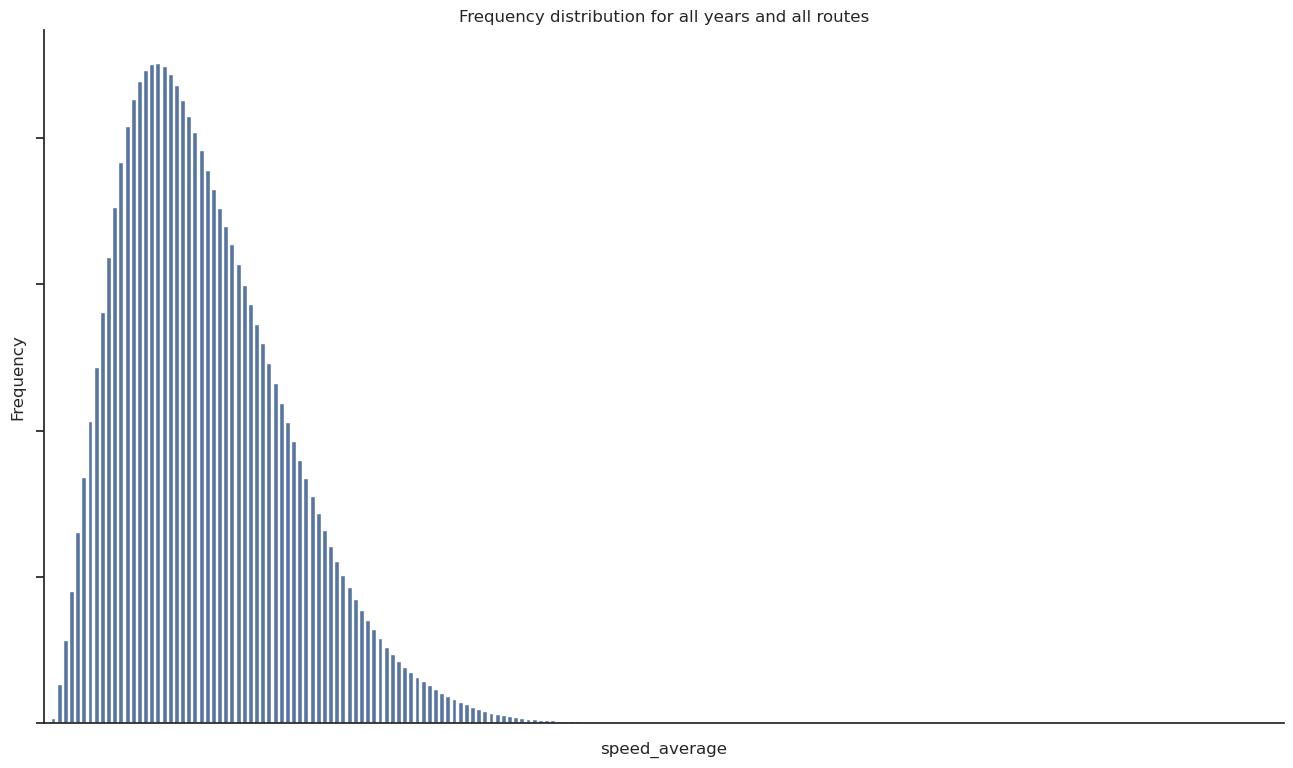

In [64]:
# Frequency distribution of speed_average
fig, ax = plt.subplots(figsize=(16, 9))
# setting the dimensions of the plot
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
dfs["frequency_distribution"] = df.select(F.round(F.col("speed_average"), 0).cast(T.IntegerType()).alias("speed_average")).groupby(F.col("speed_average")).agg(F.count(F.col("speed_average")).alias("Frequency")).toPandas()
g = sns.barplot(dfs["frequency_distribution"], x="speed_average", y="Frequency")
# Remove labels
g.set(xticklabels=[])
g.tick_params(bottom=False)
g.set(yticklabels=[])
g.set_title("Frequency distribution for all years and all routes")

# Analise $7^{ma}$


In [36]:
# Create 7ma dataset and cached it
df_kr7 = df.where(F.col("name_from") == "KR7")
df_kr7.cache()

DataFrame[start_timestamp: timestamp, year: int, hour: int, minute: int, time: string, distance: int, speed_average: double, speed_weighted: double, day_week_name: string, day_week_number: int, month_name: string, month_number: int, name_from: string, name_to: string, name_to_1: int, name_to_2: int, route_id: bigint, direction: string, num_devices: int]

In [44]:
# Resumen estadístico para KR7
df_kr7.where(F.col("year") == 2022).select(F.col("speed_average")).summary().show()

+-------+------------------+
|summary|     speed_average|
+-------+------------------+
|  count|           1615675|
|   mean| 30.38240790877126|
| stddev|10.984879898615125|
|    min|              3.96|
|    25%|             22.54|
|    50%|       30.35333333|
|    75%|             38.19|
|    max|            133.32|
+-------+------------------+



## Lineplot speed_average by year

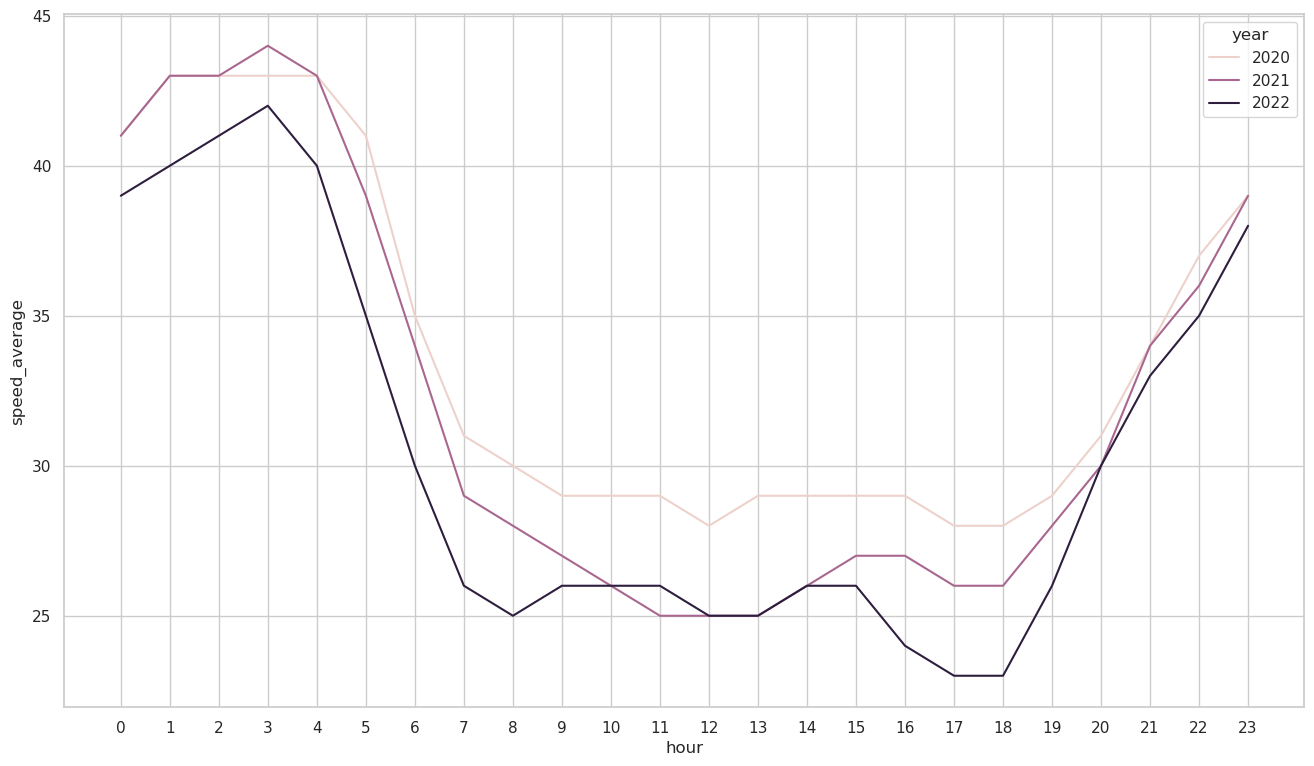

In [65]:
# Without outliers
sns.set_style("whitegrid")
dfs["lineplot_speed_average_by_year"] = df_kr7.groupby(F.col("year"), F.col("hour")).agg(F.round(F.avg(F.col("speed_average")), 0).cast(T.IntegerType()).alias("speed_average")).toPandas()
ax = sns.lineplot(data=dfs["lineplot_speed_average_by_year"], x="hour", y="speed_average", hue="year")
ax.set_xticks(range(24), labels=["0","1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23"])

## FaceGrid with speed_average by month and year

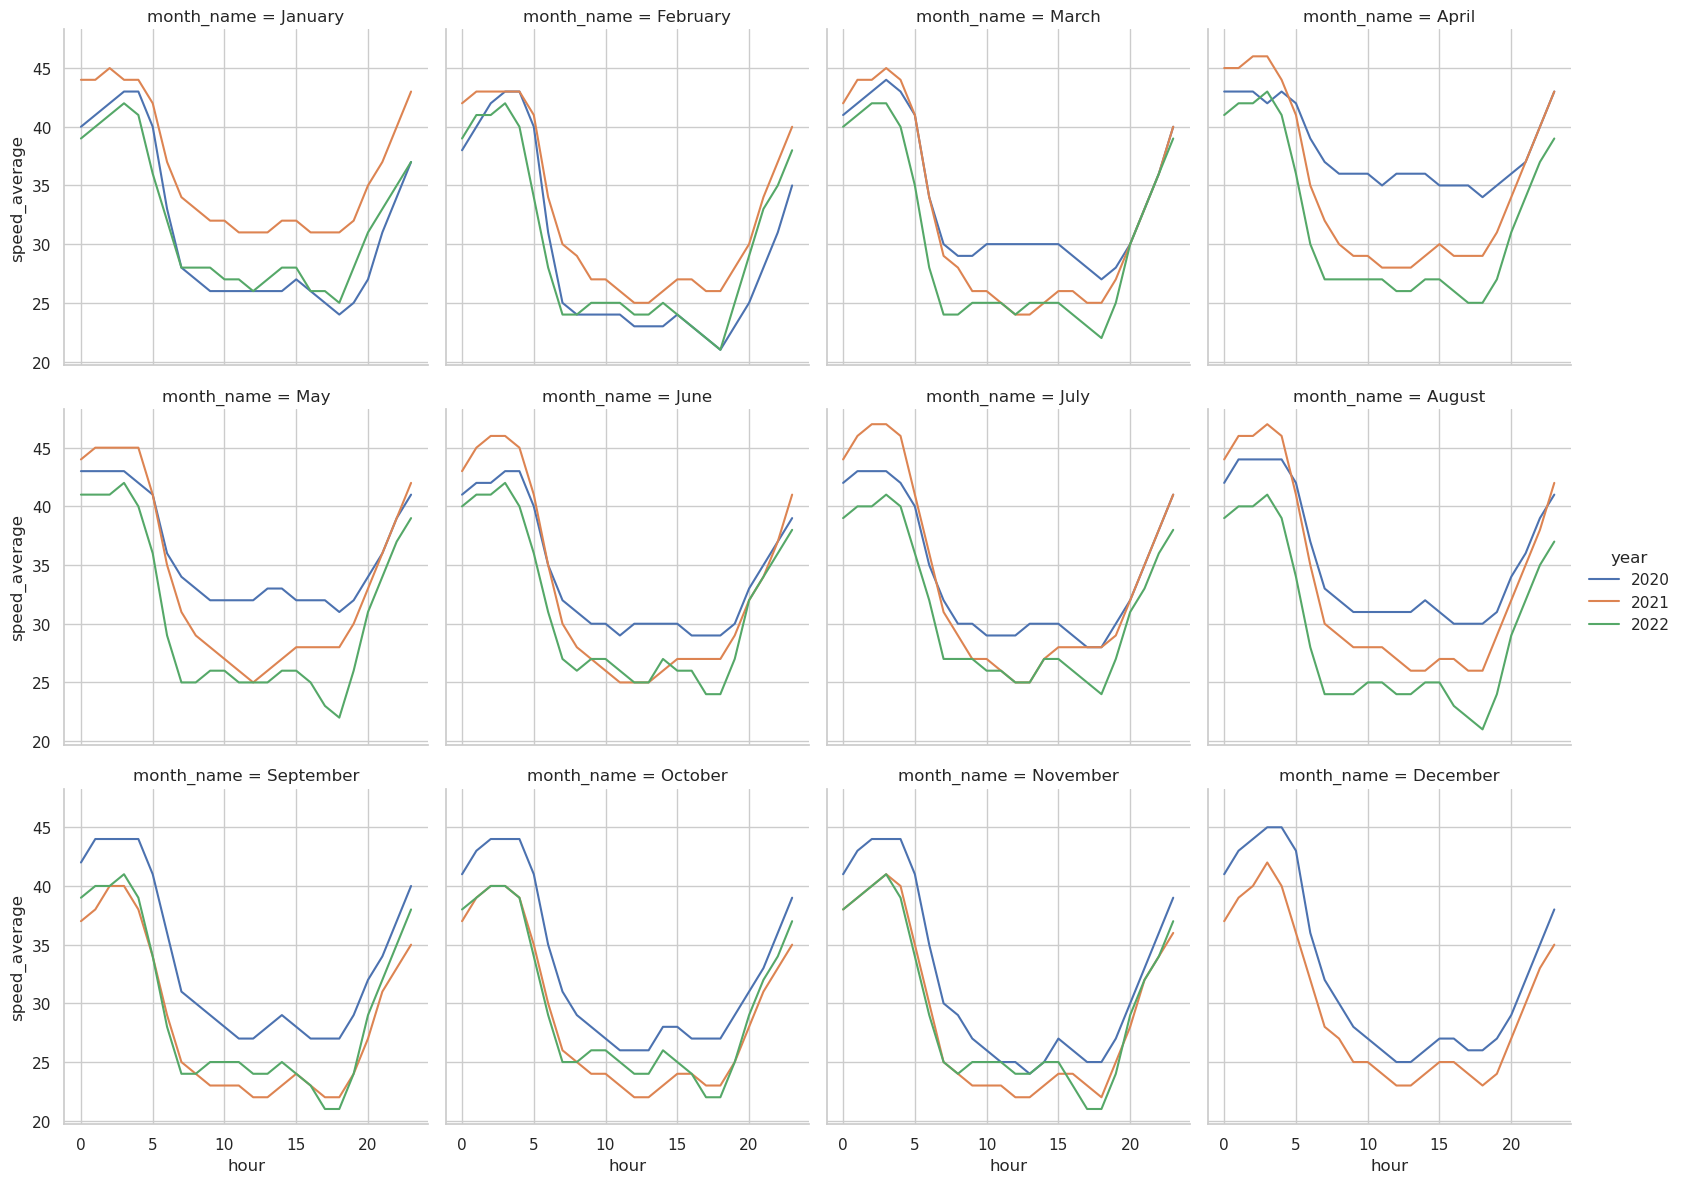

In [66]:
# Evolución de las velocidades promedio por hora por año
dfs["facegrid_with_speed_average_by_month_by_year"] = df_kr7.groupby(F.col("year"), F.col("month_number"), F.col("month_name"),F.col("hour")).agg(F.round(F.avg(F.col("speed_average")), 0).cast(T.IntegerType()).alias("speed_average")).sort(F.col("month_number")).drop(F.col("month_number")).toPandas()
g = sns.FacetGrid(data=dfs["facegrid_with_speed_average_by_month_by_year"], col="month_name", hue="year", height=4, aspect=1, col_wrap=4)
g.map(sns.lineplot, "hour", "speed_average")
g.add_legend()

## Lineplot with speed_average by direction and day of week

Text(0.5, 1.0, 'SOUTH-NORTH')

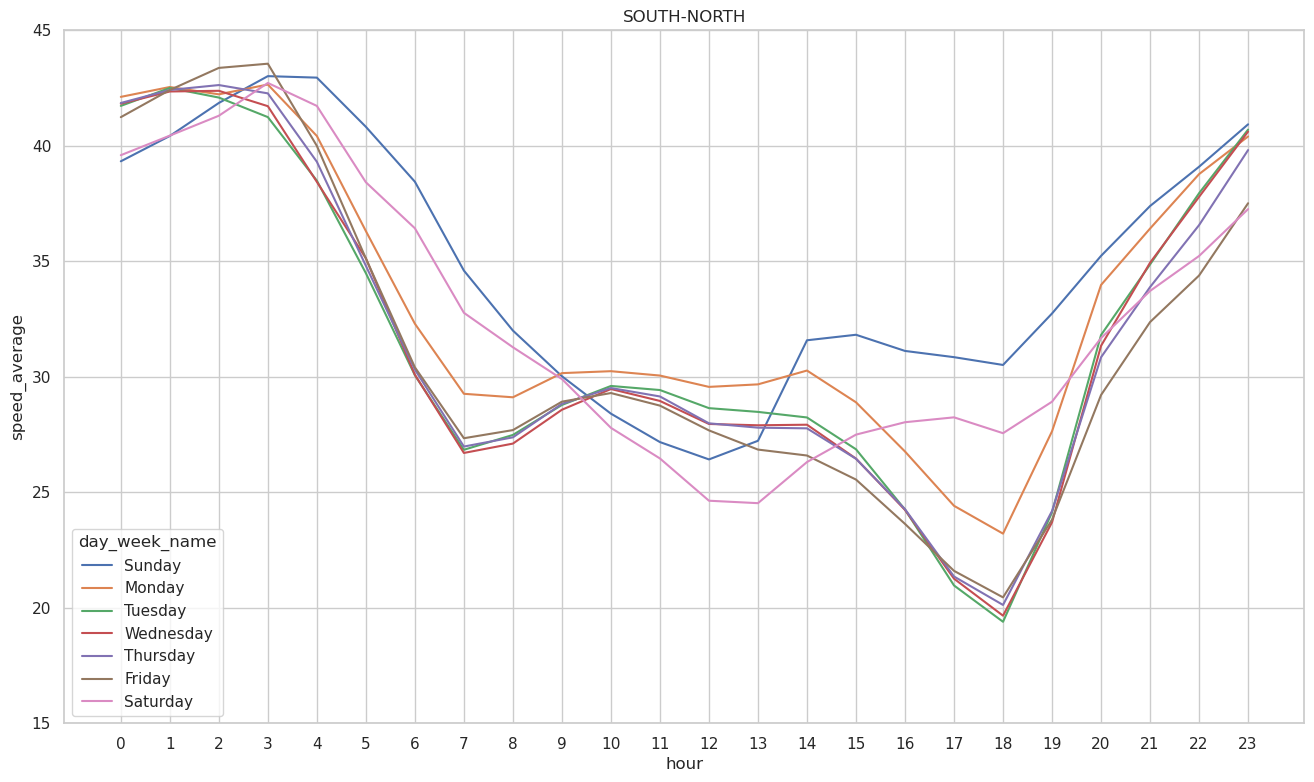

In [68]:
sns.set_style("whitegrid")
dfs["lineplot_with_speed_average_by_direction_and_day_of_week_south_north"] = df_kr7.where((F.col("year") == 2022) & (F.col("direction") == "SOUTH-NORTH")).groupby(F.col("day_week_number"),F.col("day_week_name"), F.col("direction"), F.col("hour")).agg(F.avg(F.col("speed_average")).alias("speed_average")).sort(F.col("day_week_number")).drop(F.col("day_week_number")).toPandas()
ax = sns.lineplot(data=dfs["lineplot_with_speed_average_by_direction_and_day_of_week_south_north"], x="hour", y="speed_average", hue="day_week_name")
ax.set_xticks(range(24), labels=["0","1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23"])
ax.set_yticks([15, 20, 25, 30, 35, 40, 45], ["15", "20", "25", "30", "35", "40", "45"])
ax.set_title("SOUTH-NORTH")

Text(0.5, 1.0, 'NORTH-SOUTH')

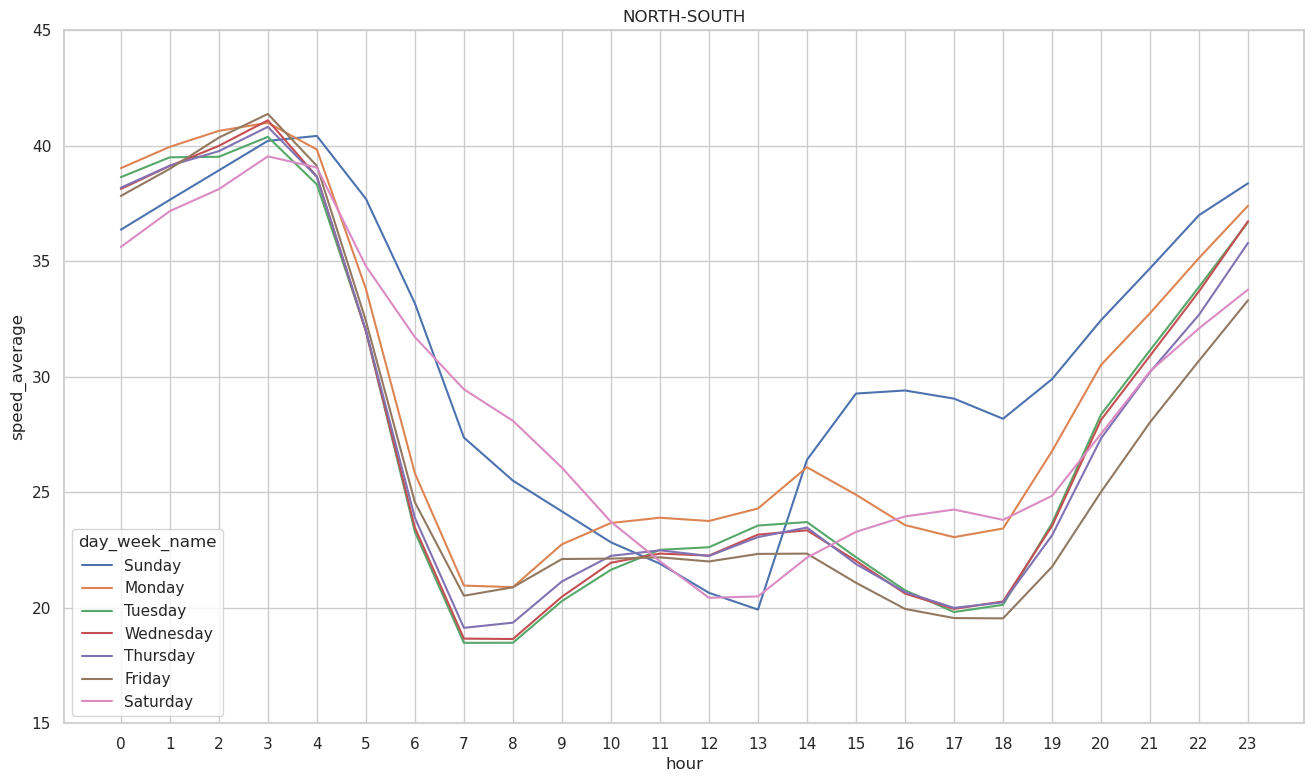

In [69]:
sns.set_style("whitegrid")
dfs["lineplot_with_speed_average_by_direction_and_day_of_week_north_south"] = df_kr7.where((F.col("year") == 2022) & (F.col("direction") == "NORTH-SOUTH")).groupby(F.col("day_week_number"),F.col("day_week_name"), F.col("direction"), F.col("hour")).agg(F.avg(F.col("speed_average")).alias("speed_average")).sort(F.col("day_week_number")).drop(F.col("day_week_number")).toPandas()
ax = sns.lineplot(data=dfs["lineplot_with_speed_average_by_direction_and_day_of_week_north_south"], x="hour", y="speed_average", hue="day_week_name")
ax.set_xticks(range(24), labels=["0","1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23"])
ax.set_yticks([15, 20, 25, 30, 35, 40, 45], ["15", "20", "25", "30", "35", "40", "45"])
ax.set_title("NORTH-SOUTH")

## Lineplot with routes

Text(0.5, 1.0, 'Hora 7')

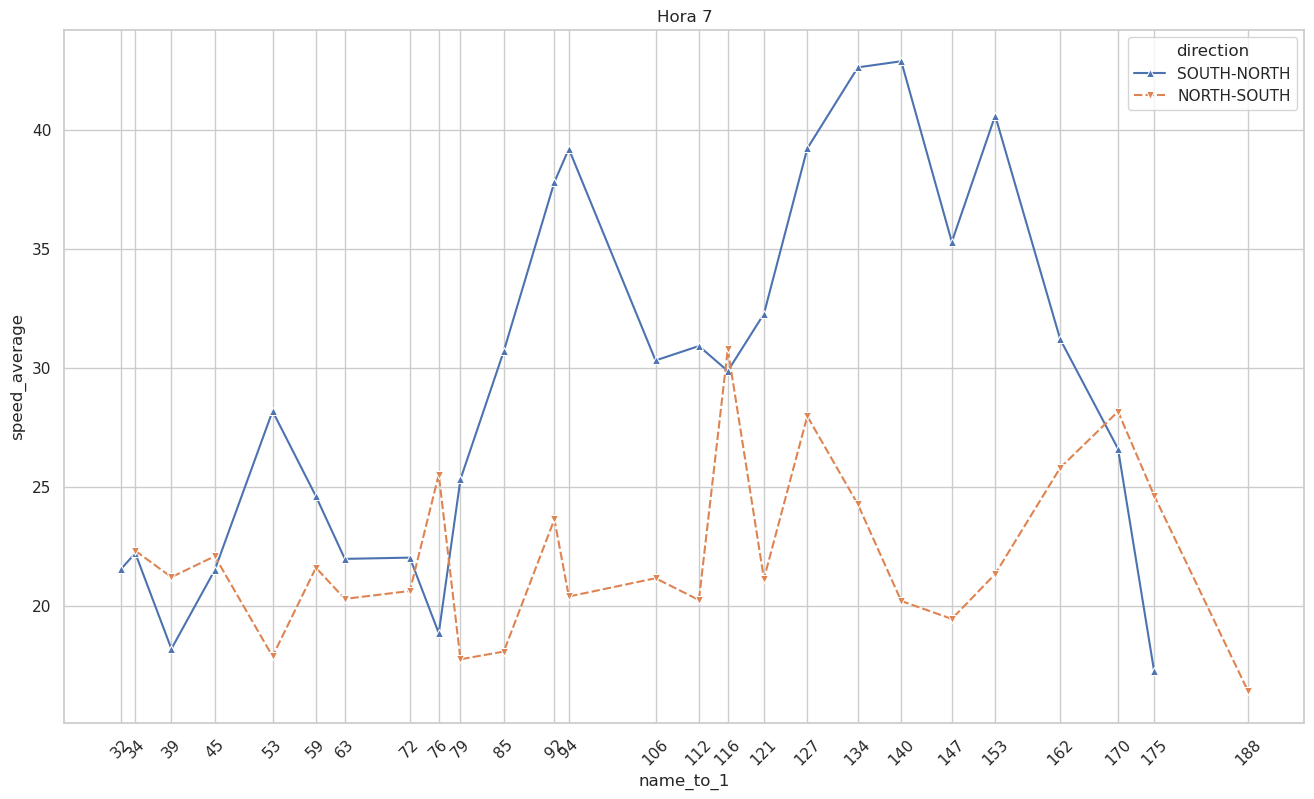

In [71]:
# Velocidades promedio por calles
# Hora 7 am
fig, ax = plt.subplots(figsize=(16, 9))
sns.set_style("whitegrid")
markers = {"NORTH-SOUTH": "v", "SOUTH-NORTH": "^"}
dfs["lineplot_with_routes_hora_7"] = df_kr7.where((F.col("hour") == 7) & (F.col("year") == 2022)).select(F.col("direction"), F.col("name_to_1"), F.col("speed_average"),).groupby(F.col("direction"), F.col("name_to_1")).agg(F.avg(F.col("speed_average")).alias("speed_average")).toPandas()
sns.lineplot(data=dfs["lineplot_with_routes_hora_7"], x="name_to_1", y="speed_average", hue="direction", ax=ax, markers=markers, style="direction")
xticks = sorted(df_kr7.where((F.col("hour") == 7) & (F.col("year") == 2022)).select(F.col("name_to_1")).distinct().rdd.flatMap(lambda x: x).collect())
ax.set_xticks(xticks, labels=list(map(str,xticks)), rotation=45)
ax.set_title("Hora 7")

Text(0.5, 1.0, 'Hora 12')

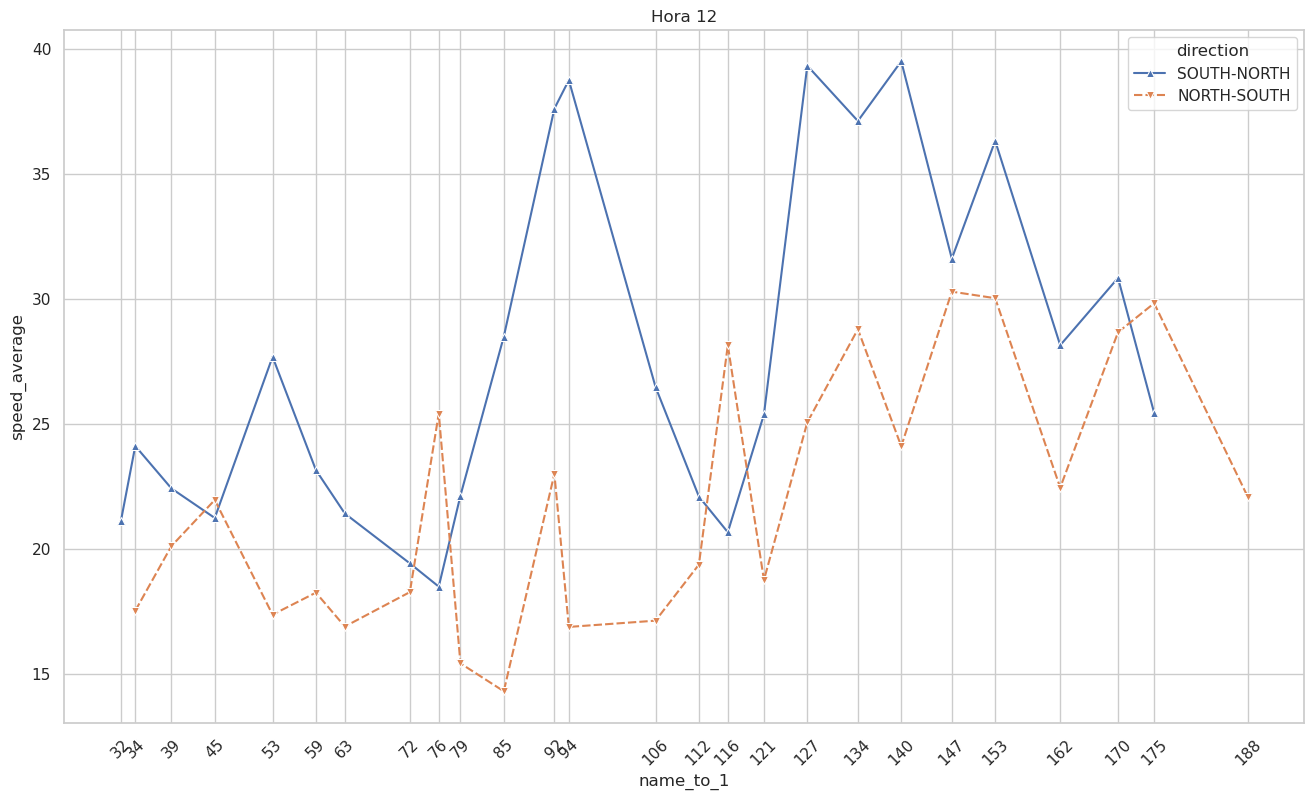

In [72]:
# Velocidades promedio por calles
fig, ax = plt.subplots(figsize=(16, 9))
sns.set_style("whitegrid")
markers = {"NORTH-SOUTH": "v", "SOUTH-NORTH": "^"}
dfs["lineplot_with_routes_hora_12"] = df_kr7.where((F.col("hour") == 12) & (F.col("year") == 2022)).select(F.col("direction"), F.col("name_to_1"), F.col("speed_average"),).groupby(F.col("direction"), F.col("name_to_1")).agg(F.avg(F.col("speed_average")).alias("speed_average")).toPandas()
sns.lineplot(data=dfs["lineplot_with_routes_hora_12"], x="name_to_1", y="speed_average", hue="direction", ax=ax, markers=markers, style="direction")
xticks = sorted(df_kr7.where((F.col("hour") == 12) & (F.col("year") == 2022)).select(F.col("name_to_1")).distinct().rdd.flatMap(lambda x: x).collect())
ax.set_xticks(xticks, labels=list(map(str,xticks)), rotation=45)
ax.set_title("Hora 12")

Text(0.5, 1.0, 'Hora 17')

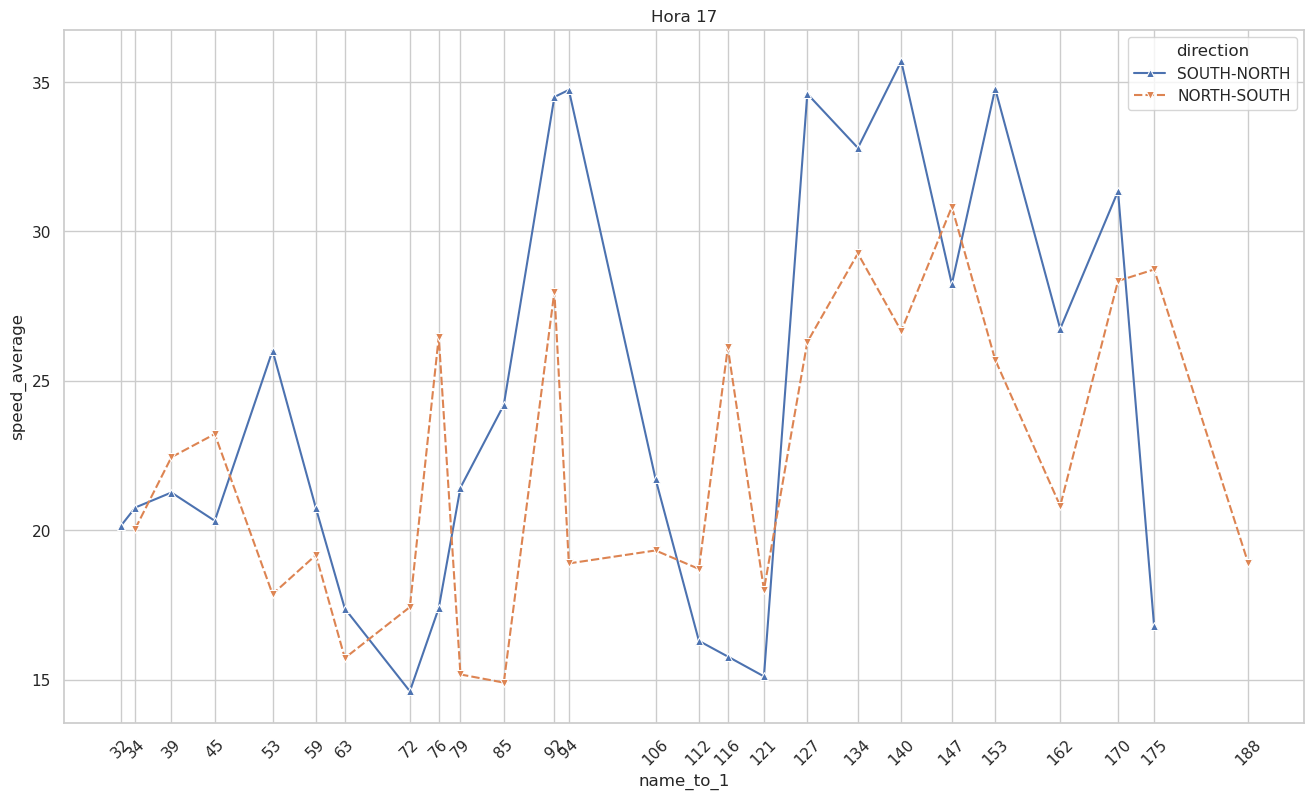

In [73]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.set_style("whitegrid")
markers = {"NORTH-SOUTH": "v", "SOUTH-NORTH": "^"}
dfs["lineplot_with_routes_hora_17"] = df_kr7.where((F.col("hour") == 17) & (F.col("year") == 2022)).select(F.col("direction"), F.col("name_to_1"), F.col("speed_average"),).groupby(F.col("direction"), F.col("name_to_1")).agg(F.avg(F.col("speed_average")).alias("speed_average")).toPandas()
sns.lineplot(data=dfs["lineplot_with_routes_hora_17"], x="name_to_1", y="speed_average", hue="direction", ax=ax, markers=markers, style="direction")
xticks = sorted(df_kr7.where((F.col("hour") == 17) & (F.col("year") == 2022)).select(F.col("name_to_1")).distinct().rdd.flatMap(lambda x: x).collect())
ax.set_xticks(xticks, labels=list(map(str,xticks)), rotation=45)
ax.set_title("Hora 17")

## Heatmaps

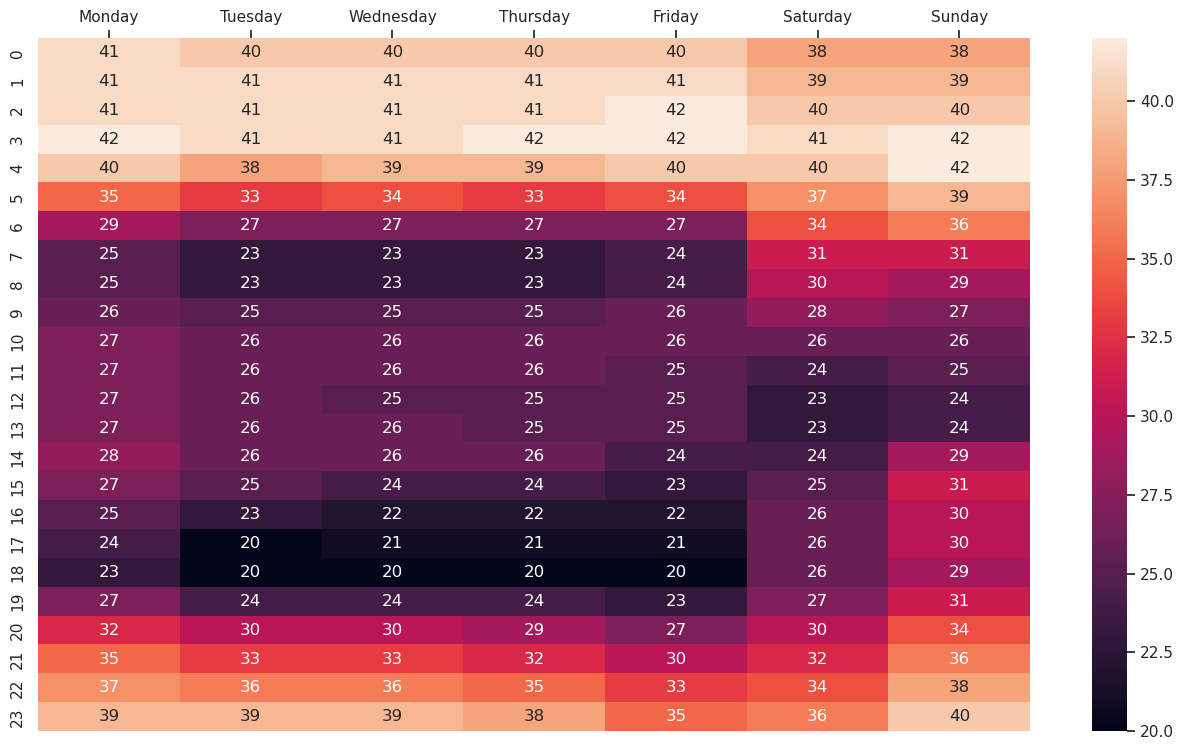

In [74]:
dfs["heatmap_2022"] = df_kr7.where(F.col("year") == 2022).groupby(F.col("day_week_number"), F.col("day_week_name"), F.col("hour")).agg(F.round(F.avg(F.col("speed_average")), 0).cast(T.IntegerType()).alias("speed_average")).toPandas().pivot(index="hour", columns="day_week_name", values="speed_average")[["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]]
ax = sns.heatmap(dfs["heatmap_2022"], annot=True)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()

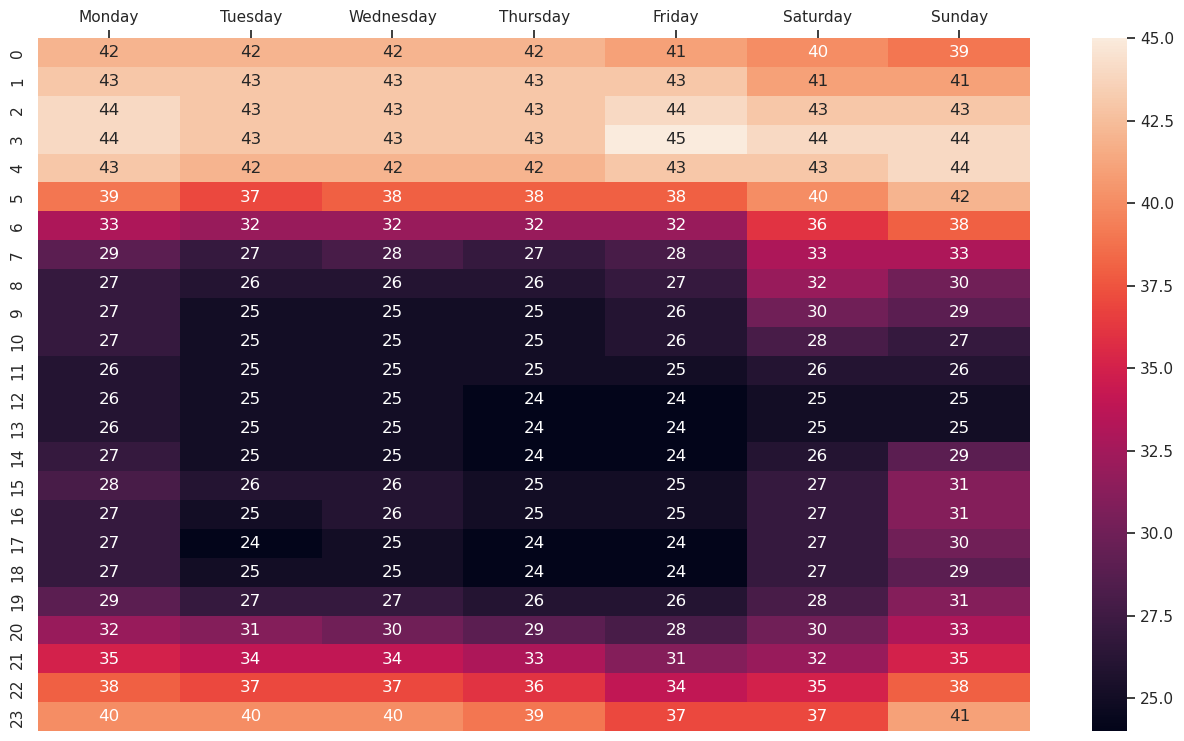

In [75]:
dfs["heatmap_2021"] = df_kr7.where(F.col("year") == 2021).groupby(F.col("day_week_number"), F.col("day_week_name"), F.col("hour")).agg(F.round(F.avg(F.col("speed_average")), 0).cast(T.IntegerType()).alias("speed_average")).toPandas().pivot(index="hour", columns="day_week_name", values="speed_average")[["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]]
ax = sns.heatmap(dfs["heatmap_2021"], annot=True)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()

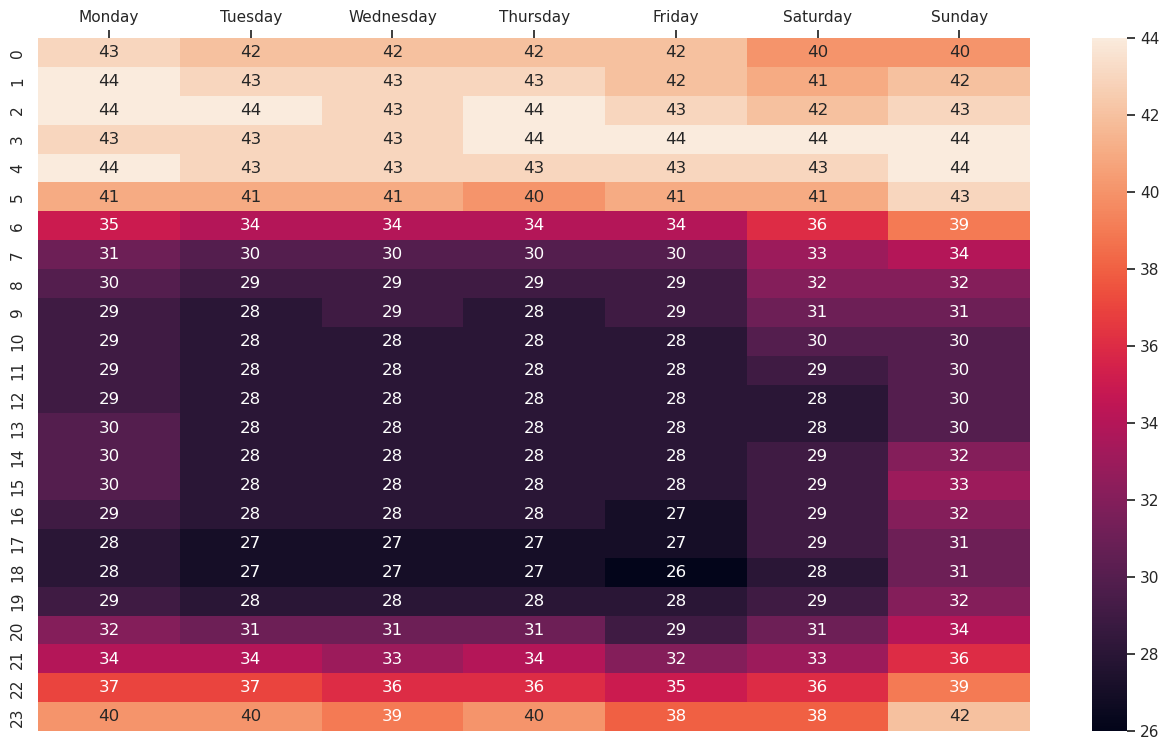

In [76]:
dfs["heatmap_2020"] = df_kr7.where(F.col("year") == 2020).groupby(F.col("day_week_number"), F.col("day_week_name"), F.col("hour")).agg(F.round(F.avg(F.col("speed_average")), 0).cast(T.IntegerType()).alias("speed_average")).toPandas().pivot(index="hour", columns="day_week_name", values="speed_average")[["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]]
ax = sns.heatmap(dfs["heatmap_2020"], annot=True)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()

## Export pandas to CSV

In [87]:
!mkdir -p /tmp/TFM/output

In [77]:
for df_name in dfs:
    dfs[df_name].to_csv(f"/tmp/TFM/output/{df_name}.csv", index=True)

frequency_distribution
lineplot_speed_average_by_year
facegrid_with_speed_average_by_month_by_year
lineplot_with_speed_average_by_direction_and_day_of_week
lineplot_with_speed_average_by_direction_and_day_of_week_south_north
lineplot_with_speed_average_by_direction_and_day_of_week_north_south
lineplot_with_routes
lineplot_with_routes_hora_7
lineplot_with_routes_hora_12
lineplot_with_routes_hora_17
heatmap_2022
heatmap_2021
heatmap_2020


# Stop spark

In [164]:
df_kr7.unpersist()
spark.stop()